# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [5]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            # print(X.shape)
            # input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            # print('y shape')
            # print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            # print(y.shape)
            # print(' y hat shape')
            # print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [6]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [204]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


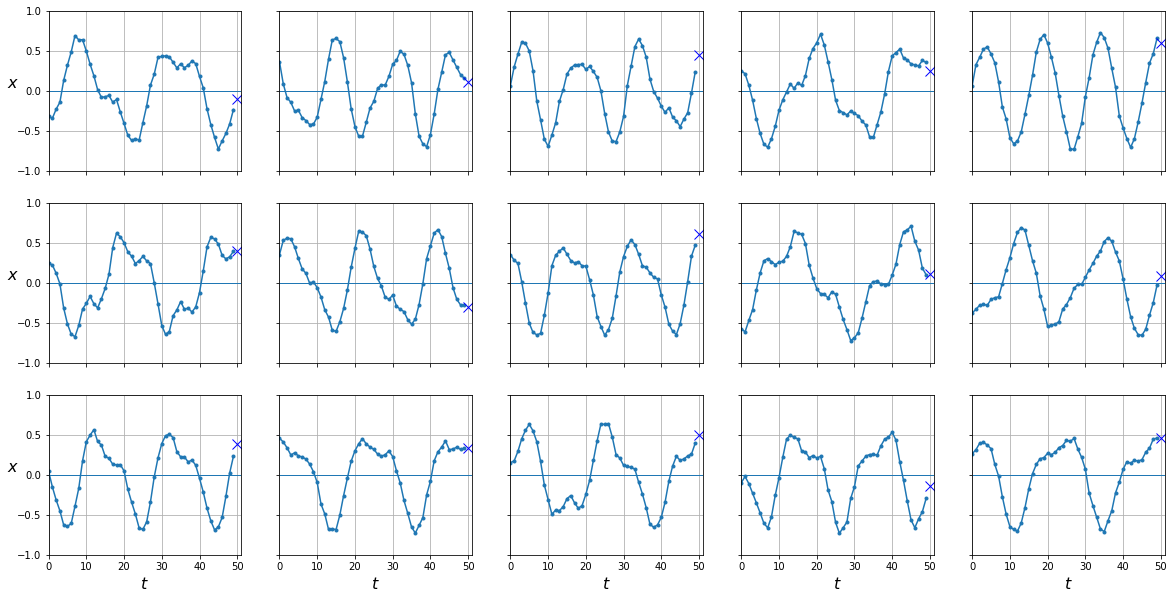

In [205]:
plot_series(X_test, y_test)

In [206]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [207]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [208]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.06172: 100%|██████████| 32/32 [00:00<00:00, 352.53it/s]


epoch numero:  1


valid_loss 0.03740: 100%|██████████| 32/32 [00:00<00:00, 320.88it/s]


epoch numero:  2


valid_loss 0.02582: 100%|██████████| 32/32 [00:00<00:00, 717.45it/s]


epoch numero:  3


valid_loss 0.01961: 100%|██████████| 32/32 [00:00<00:00, 622.77it/s]


epoch numero:  4


valid_loss 0.01621: 100%|██████████| 32/32 [00:00<00:00, 770.07it/s]


epoch numero:  5


valid_loss 0.01402: 100%|██████████| 32/32 [00:00<00:00, 356.54it/s]


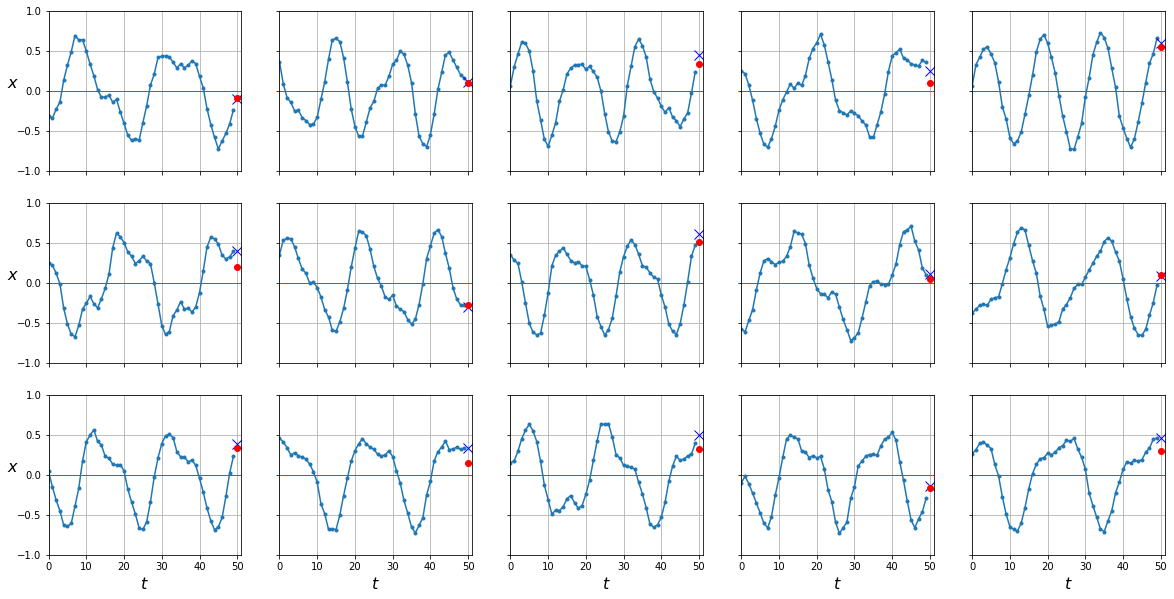

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.014442238

In [209]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Veamos ahora una RNN básica de 1 sola neurona

In [210]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salidas
    #return x[:,-10:]
    return x[:,-1:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [211]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.2236, 0.3867, 0.4337, 0.5839, 0.4161, 0.8983, 0.6780, 0.0347, 0.3838,
        0.1814, 0.2137, 0.0359, 0.9506, 0.6126, 0.2161, 0.7225, 0.7397, 0.9370,
        0.4715, 0.7917, 0.5731, 0.9568, 0.6585, 0.5911, 0.0475, 0.1756, 0.2916,
        0.9048, 0.6881, 0.0455, 0.9714, 0.3017, 0.7410, 0.4468, 0.6733, 0.5438,
        0.7551, 0.9494, 0.7820, 0.1900, 0.6081, 0.7709, 0.3560, 0.8626, 0.2273,
        0.4905, 0.3443, 0.9336, 0.6555, 0.8206])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [212]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.9549]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [213]:
# ahora el vamos a pasar un set del dataset...

In [214]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [215]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [216]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.18961: 100%|██████████| 32/32 [00:00<00:00, 299.83it/s]


epoch numero:  1


valid_loss 0.09586: 100%|██████████| 32/32 [00:00<00:00, 287.36it/s]


epoch numero:  2


valid_loss 0.05433: 100%|██████████| 32/32 [00:00<00:00, 250.59it/s]


epoch numero:  3


valid_loss 0.03858: 100%|██████████| 32/32 [00:00<00:00, 297.61it/s]


epoch numero:  4


valid_loss 0.03257: 100%|██████████| 32/32 [00:00<00:00, 204.37it/s]


epoch numero:  5


valid_loss 0.02985: 100%|██████████| 32/32 [00:00<00:00, 183.35it/s]


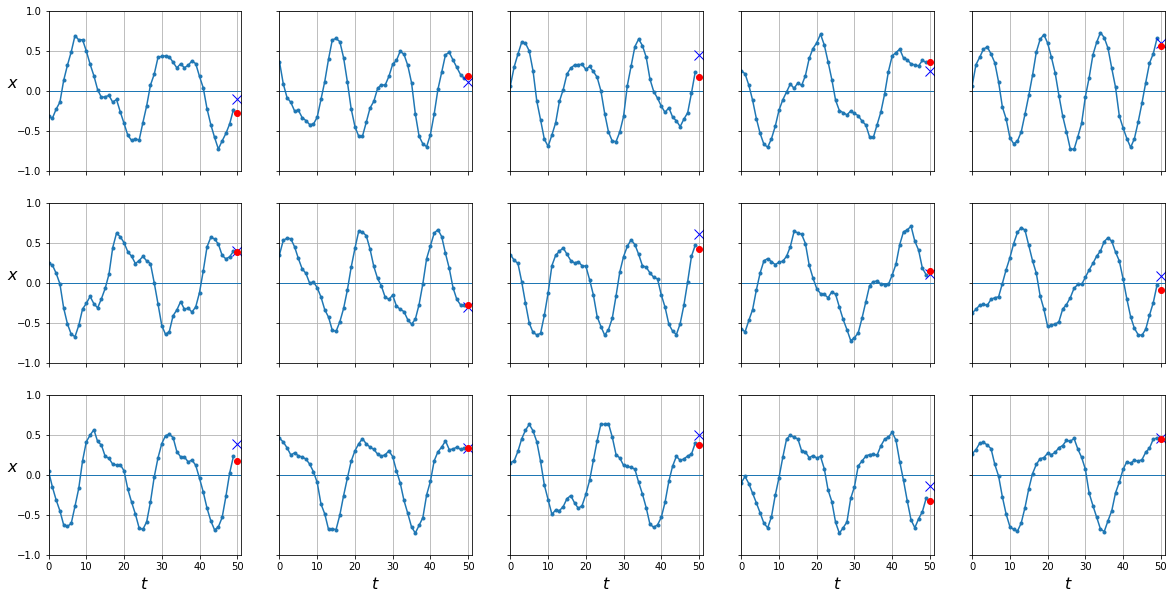

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.029529534

In [217]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu()))

## Comparacion de parámetros entre MLP y RNN implementada

In [218]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [219]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])



## Incorporamos más neuronas en la RNN

In [220]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [221]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [222]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.9365, 0.3387, 0.9042, 0.1818, 0.2478, 0.1851, 0.0056, 0.9117, 0.2408,
        0.9080, 0.8835, 0.6824, 0.9805, 0.1340, 0.3419, 0.8841, 0.1193, 0.1171,
        0.7729, 0.6916])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [223]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.1381]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 1])


In [224]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.02439: 100%|██████████| 32/32 [00:00<00:00, 314.53it/s]


epoch numero:  1


valid_loss 0.00931: 100%|██████████| 32/32 [00:00<00:00, 376.90it/s]


epoch numero:  2


valid_loss 0.00711: 100%|██████████| 32/32 [00:00<00:00, 342.82it/s]


epoch numero:  3


valid_loss 0.00591: 100%|██████████| 32/32 [00:00<00:00, 185.29it/s]


epoch numero:  4


valid_loss 0.00501: 100%|██████████| 32/32 [00:00<00:00, 301.70it/s]


epoch numero:  5


valid_loss 0.00543: 100%|██████████| 32/32 [00:00<00:00, 312.90it/s]


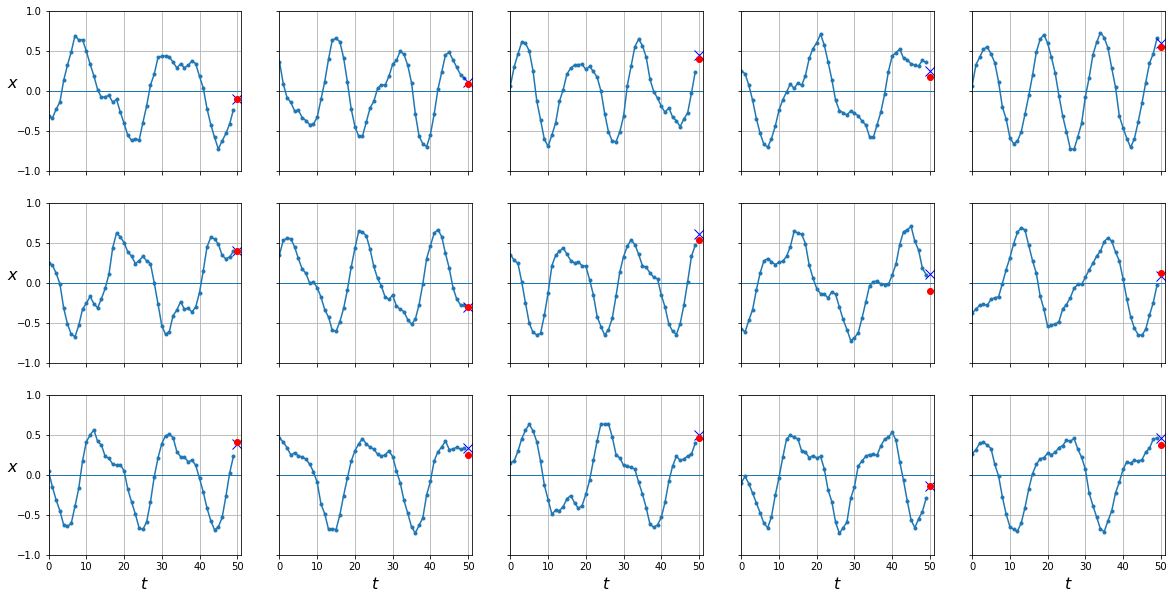

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0057347496

In [225]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [226]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [227]:
rnn_deep = DeepRNN()
imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [228]:

fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.00937: 100%|██████████| 32/32 [00:00<00:00, 166.48it/s]


epoch numero:  1


valid_loss 0.00495: 100%|██████████| 32/32 [00:00<00:00, 176.10it/s]


epoch numero:  2


valid_loss 0.00422: 100%|██████████| 32/32 [00:00<00:00, 162.87it/s]


epoch numero:  3


valid_loss 0.00377: 100%|██████████| 32/32 [00:00<00:00, 156.32it/s]


epoch numero:  4


valid_loss 0.00357: 100%|██████████| 32/32 [00:00<00:00, 145.16it/s]


epoch numero:  5


valid_loss 0.00347: 100%|██████████| 32/32 [00:00<00:00, 141.97it/s]


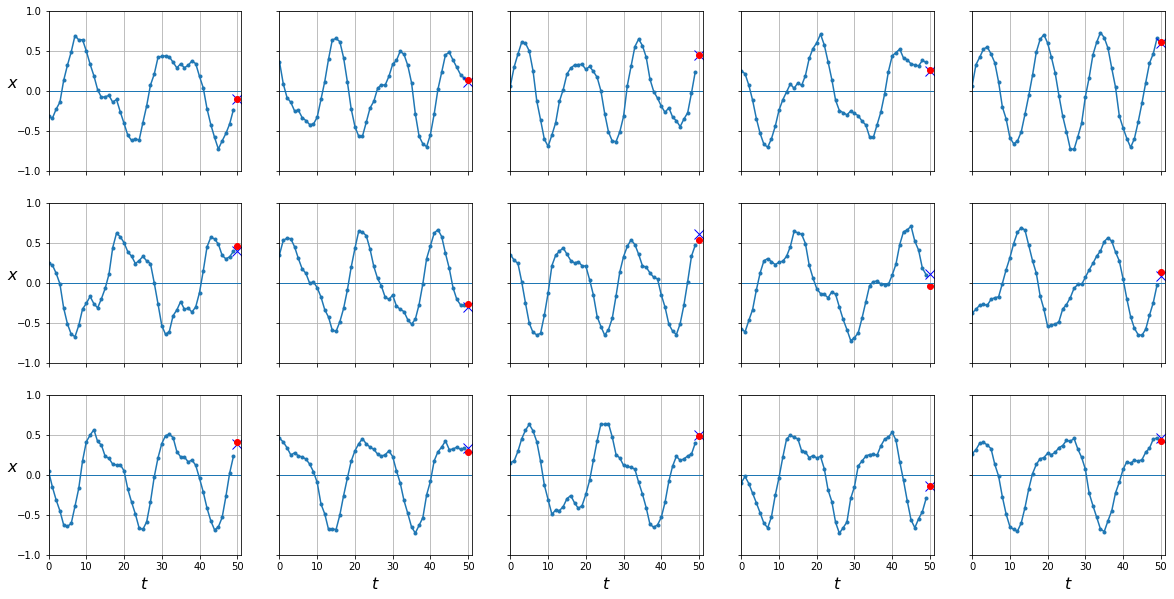

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0035215497

In [229]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu()))

In [230]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



# predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


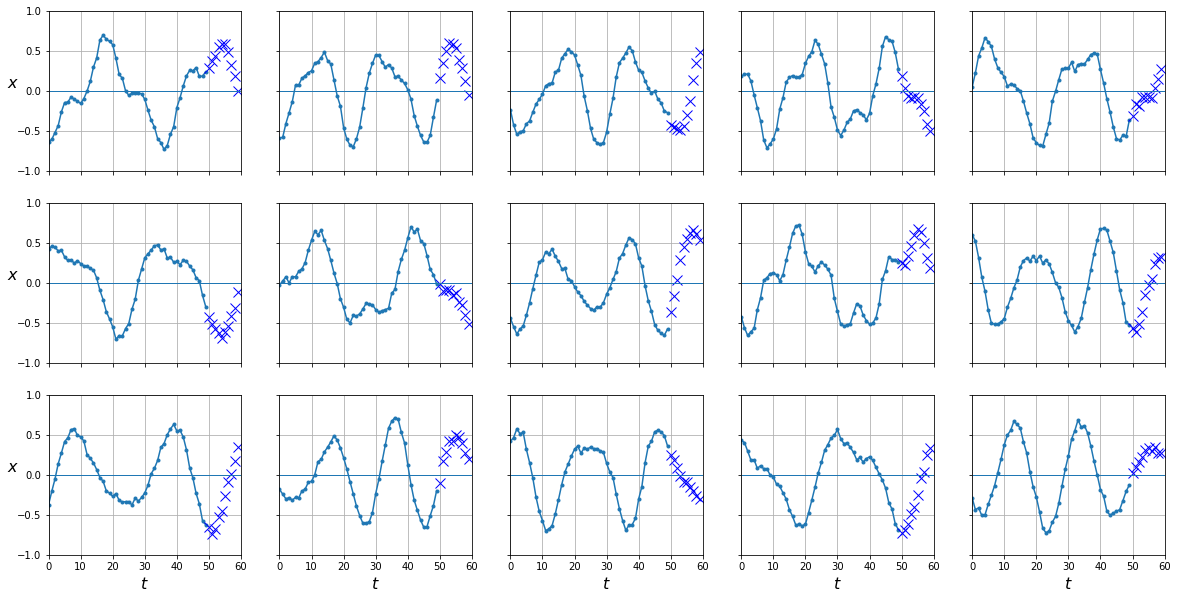

(1000, 10, 1)
(1000, 1, 1)


In [309]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [310]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [311]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [312]:
# entreno de nueva la ultima red y graficamos
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.00909: 100%|██████████| 32/32 [00:00<00:00, 129.32it/s]


epoch numero:  1


valid_loss 0.00497: 100%|██████████| 32/32 [00:00<00:00, 120.17it/s]


epoch numero:  2


valid_loss 0.00374: 100%|██████████| 32/32 [00:00<00:00, 191.00it/s]


epoch numero:  3


valid_loss 0.00349: 100%|██████████| 32/32 [00:00<00:00, 169.80it/s]


epoch numero:  4


valid_loss 0.00323: 100%|██████████| 32/32 [00:00<00:00, 140.73it/s]


epoch numero:  5


valid_loss 0.00306: 100%|██████████| 32/32 [00:00<00:00, 157.28it/s]


In [313]:
print(xs.shape)
#predict(rnn_deep, xs)
sal = rnn_deep(xs.to('cuda'))
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


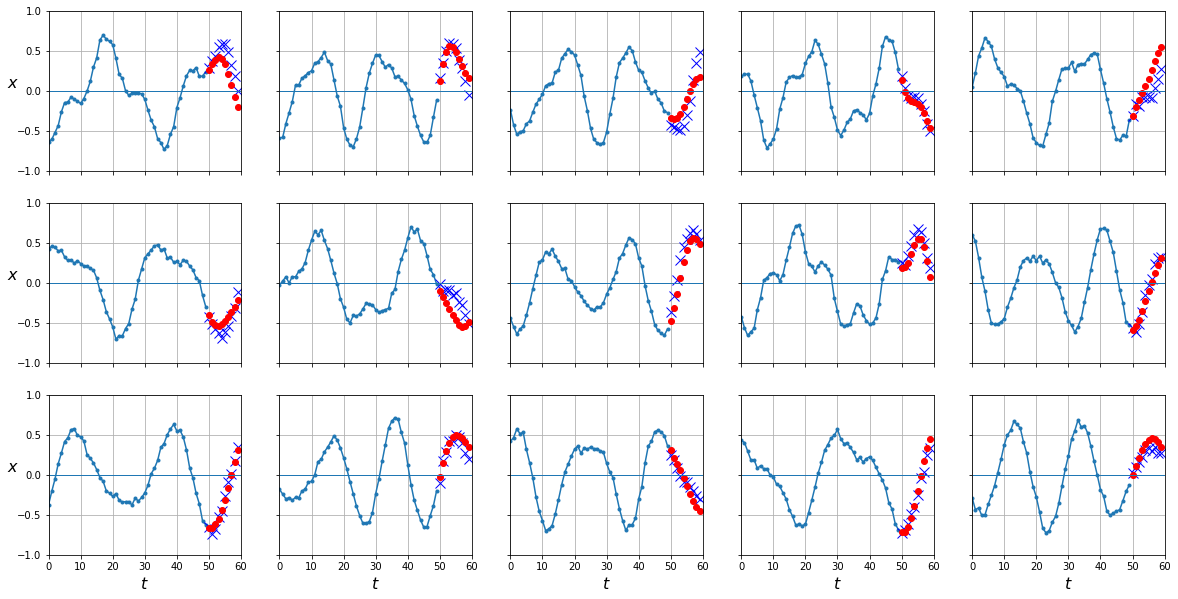

(1000, 10, 1)
(1000, 10)


0.026519239

In [314]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.00353: 100%|██████████| 32/32 [00:00<00:00, 246.81it/s]


epoch numero:  1


valid_loss 0.00336: 100%|██████████| 32/32 [00:00<00:00, 297.59it/s]


epoch numero:  2


valid_loss 0.00327: 100%|██████████| 32/32 [00:00<00:00, 294.37it/s]


epoch numero:  3


valid_loss 0.00313: 100%|██████████| 32/32 [00:00<00:00, 337.74it/s]


epoch numero:  4


valid_loss 0.00306: 100%|██████████| 32/32 [00:00<00:00, 706.13it/s]


epoch numero:  5


valid_loss 0.00306: 100%|██████████| 32/32 [00:00<00:00, 394.64it/s]


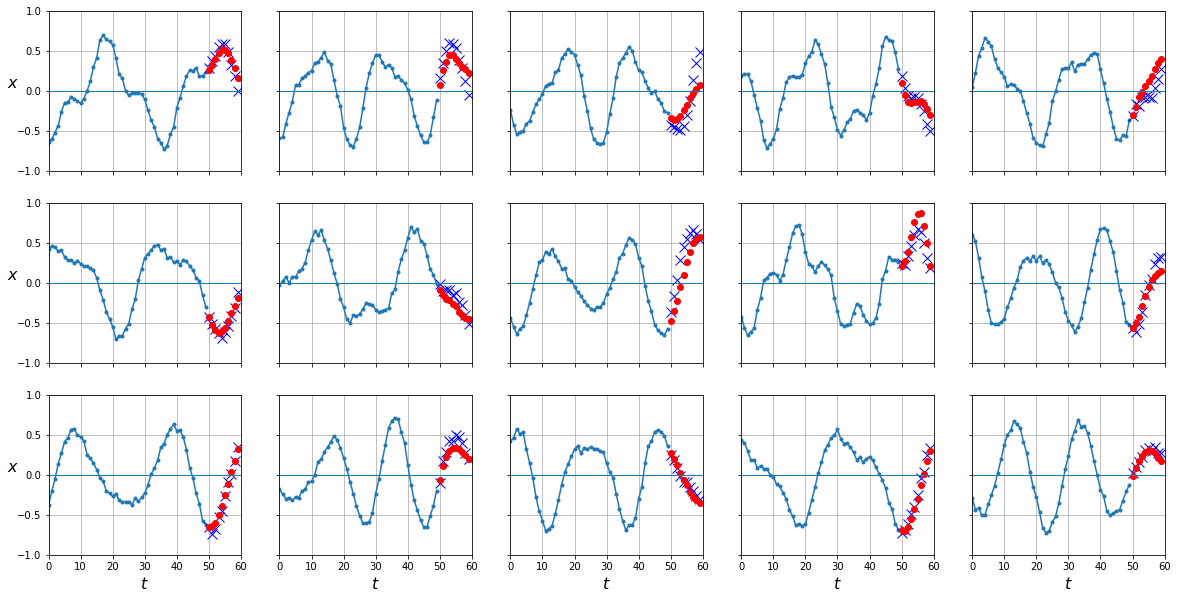

(1000, 10, 1)
(1000, 10)


0.018011648

In [315]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


## Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. Asegurarse de compararlos con el mismo set datos!!

Se cambia el learning rate para llegar a mejores resultados en ambos modelos

In [40]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            # print(X.shape)
            # input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            # print('y shape')
            # print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            # print(y.shape)
            # print(' y hat shape')
            # print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

Se generan los datos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


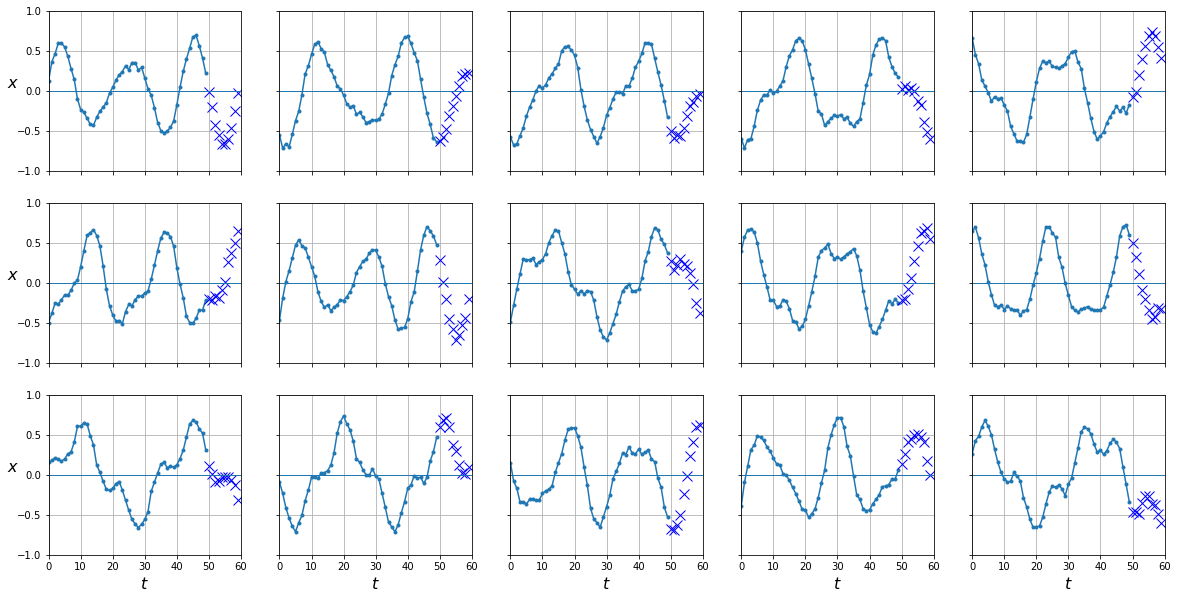

(1000, 10, 1)
(1000, 1, 1)


In [41]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10


series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [42]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))

<class 'dict'>


In [47]:
EPOCHS = 50

MLP 10 muestras futuras


In [48]:
class MLP_10(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp_10 = MLP_10(n_steps, n_future)
mlp_10

MLP_10(
  (fc): Linear(in_features=50, out_features=10, bias=True)
)

In [49]:
fit(mlp_10, dataloader, epochs = EPOCHS)

epoch numero:  0


valid_loss 0.15272: 100%|██████████| 32/32 [00:00<00:00, 401.04it/s]


epoch numero:  1


valid_loss 0.12645: 100%|██████████| 32/32 [00:00<00:00, 341.33it/s]


epoch numero:  2


valid_loss 0.10809: 100%|██████████| 32/32 [00:00<00:00, 534.75it/s]


epoch numero:  3


valid_loss 0.09494: 100%|██████████| 32/32 [00:00<00:00, 345.00it/s]


epoch numero:  4


valid_loss 0.08529: 100%|██████████| 32/32 [00:00<00:00, 451.91it/s]


epoch numero:  5


valid_loss 0.07810: 100%|██████████| 32/32 [00:00<00:00, 605.39it/s]


epoch numero:  6


valid_loss 0.07256: 100%|██████████| 32/32 [00:00<00:00, 517.49it/s]


epoch numero:  7


valid_loss 0.06819: 100%|██████████| 32/32 [00:00<00:00, 493.63it/s]


epoch numero:  8


valid_loss 0.06466: 100%|██████████| 32/32 [00:00<00:00, 571.19it/s]


epoch numero:  9


valid_loss 0.06169: 100%|██████████| 32/32 [00:00<00:00, 525.97it/s]


epoch numero:  10


valid_loss 0.05914: 100%|██████████| 32/32 [00:00<00:00, 458.34it/s]


epoch numero:  11


valid_loss 0.05695: 100%|██████████| 32/32 [00:00<00:00, 481.96it/s]


epoch numero:  12


valid_loss 0.05499: 100%|██████████| 32/32 [00:00<00:00, 486.16it/s]


epoch numero:  13


valid_loss 0.05325: 100%|██████████| 32/32 [00:00<00:00, 377.49it/s]


epoch numero:  14


valid_loss 0.05165: 100%|██████████| 32/32 [00:00<00:00, 493.87it/s]


epoch numero:  15


valid_loss 0.05016: 100%|██████████| 32/32 [00:00<00:00, 493.63it/s]


epoch numero:  16


valid_loss 0.04881: 100%|██████████| 32/32 [00:00<00:00, 594.23it/s]


epoch numero:  17


valid_loss 0.04755: 100%|██████████| 32/32 [00:00<00:00, 465.01it/s]


epoch numero:  18


valid_loss 0.04636: 100%|██████████| 32/32 [00:00<00:00, 433.06it/s]


epoch numero:  19


valid_loss 0.04530: 100%|██████████| 32/32 [00:00<00:00, 534.76it/s]


epoch numero:  20


valid_loss 0.04429: 100%|██████████| 32/32 [00:00<00:00, 501.33it/s]


epoch numero:  21


valid_loss 0.04331: 100%|██████████| 32/32 [00:00<00:00, 501.34it/s]


epoch numero:  22


valid_loss 0.04239: 100%|██████████| 32/32 [00:00<00:00, 465.37it/s]


epoch numero:  23


valid_loss 0.04157: 100%|██████████| 32/32 [00:00<00:00, 485.92it/s]


epoch numero:  24


valid_loss 0.04075: 100%|██████████| 32/32 [00:00<00:00, 517.22it/s]


epoch numero:  25


valid_loss 0.04001: 100%|██████████| 32/32 [00:00<00:00, 445.62it/s]


epoch numero:  26


valid_loss 0.03931: 100%|██████████| 32/32 [00:00<00:00, 594.18it/s]


epoch numero:  27


valid_loss 0.03863: 100%|██████████| 32/32 [00:00<00:00, 451.66it/s]


epoch numero:  28


valid_loss 0.03803: 100%|██████████| 32/32 [00:00<00:00, 617.02it/s]


epoch numero:  29


valid_loss 0.03740: 100%|██████████| 32/32 [00:00<00:00, 411.34it/s]


epoch numero:  30


valid_loss 0.03684: 100%|██████████| 32/32 [00:00<00:00, 478.89it/s]


epoch numero:  31


valid_loss 0.03628: 100%|██████████| 32/32 [00:00<00:00, 517.52it/s]


epoch numero:  32


valid_loss 0.03575: 100%|██████████| 32/32 [00:00<00:00, 478.88it/s]


epoch numero:  33


valid_loss 0.03526: 100%|██████████| 32/32 [00:00<00:00, 451.91it/s]


epoch numero:  34


valid_loss 0.03477: 100%|██████████| 32/32 [00:00<00:00, 509.29it/s]


epoch numero:  35


valid_loss 0.03428: 100%|██████████| 32/32 [00:00<00:00, 468.27it/s]


epoch numero:  36


valid_loss 0.03390: 100%|██████████| 32/32 [00:00<00:00, 438.64it/s]


epoch numero:  37


valid_loss 0.03347: 100%|██████████| 32/32 [00:00<00:00, 525.97it/s]


epoch numero:  38


valid_loss 0.03303: 100%|██████████| 32/32 [00:00<00:00, 534.47it/s]


epoch numero:  39


valid_loss 0.03267: 100%|██████████| 32/32 [00:00<00:00, 562.91it/s]


epoch numero:  40


valid_loss 0.03230: 100%|██████████| 32/32 [00:00<00:00, 451.92it/s]


epoch numero:  41


valid_loss 0.03193: 100%|██████████| 32/32 [00:00<00:00, 493.60it/s]


epoch numero:  42


valid_loss 0.03159: 100%|██████████| 32/32 [00:00<00:00, 562.94it/s]


epoch numero:  43


valid_loss 0.03125: 100%|██████████| 32/32 [00:00<00:00, 543.85it/s]


epoch numero:  44


valid_loss 0.03093: 100%|██████████| 32/32 [00:00<00:00, 485.94it/s]


epoch numero:  45


valid_loss 0.03063: 100%|██████████| 32/32 [00:00<00:00, 552.86it/s]


epoch numero:  46


valid_loss 0.03033: 100%|██████████| 32/32 [00:00<00:00, 562.55it/s]


epoch numero:  47


valid_loss 0.03003: 100%|██████████| 32/32 [00:00<00:00, 534.48it/s]


epoch numero:  48


valid_loss 0.02975: 100%|██████████| 32/32 [00:00<00:00, 509.28it/s]


epoch numero:  49


valid_loss 0.02948: 100%|██████████| 32/32 [00:00<00:00, 617.06it/s]


epoch numero:  50


valid_loss 0.02922: 100%|██████████| 32/32 [00:00<00:00, 433.60it/s]


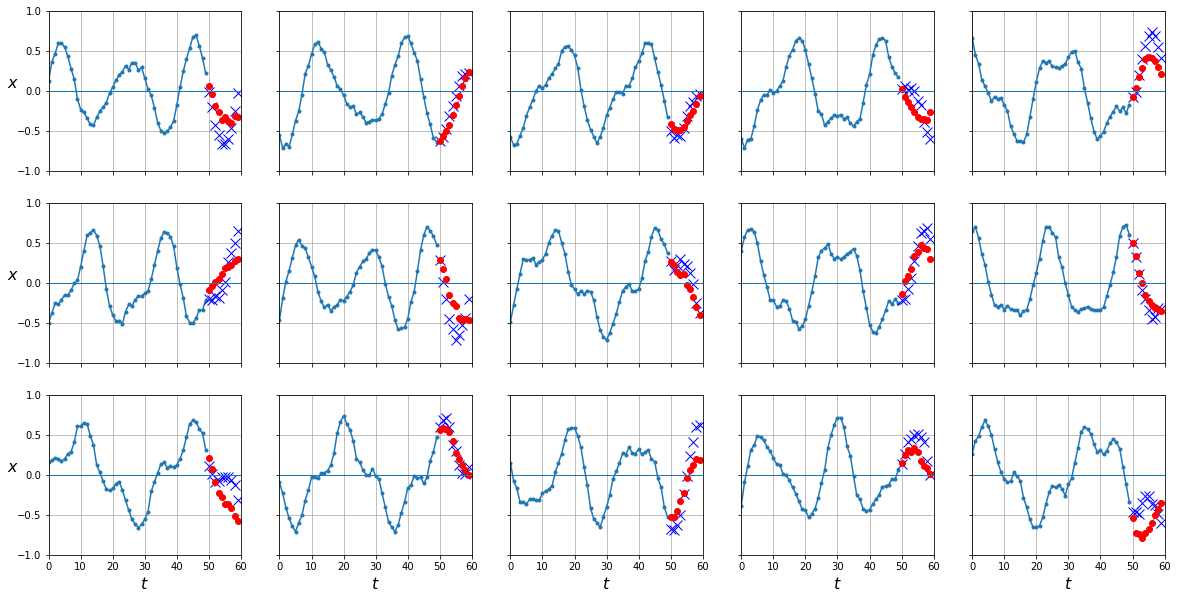

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.030284554

In [50]:
y_pred = predict(mlp_10, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

RNN 10 muestras a futuro

In [66]:
class DeepRNN_10(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [67]:
rnn_deep_10 = DeepRNN_10()
# imp_param(rnn_deep_10)

In [68]:
fit(rnn_deep_10, dataloader, epochs=EPOCHS)

epoch numero:  0


valid_loss 0.17754: 100%|██████████| 32/32 [00:00<00:00, 159.67it/s]


epoch numero:  1


valid_loss 0.14803: 100%|██████████| 32/32 [00:00<00:00, 164.93it/s]


epoch numero:  2


valid_loss 0.13894: 100%|██████████| 32/32 [00:00<00:00, 155.74it/s]


epoch numero:  3


valid_loss 0.13270: 100%|██████████| 32/32 [00:00<00:00, 163.70it/s]


epoch numero:  4


valid_loss 0.12079: 100%|██████████| 32/32 [00:00<00:00, 152.79it/s]


epoch numero:  5


valid_loss 0.10549: 100%|██████████| 32/32 [00:00<00:00, 150.63it/s]


epoch numero:  6


valid_loss 0.09517: 100%|██████████| 32/32 [00:00<00:00, 171.58it/s]


epoch numero:  7


valid_loss 0.08526: 100%|██████████| 32/32 [00:00<00:00, 170.20it/s]


epoch numero:  8


valid_loss 0.07128: 100%|██████████| 32/32 [00:00<00:00, 165.39it/s]


epoch numero:  9


valid_loss 0.05969: 100%|██████████| 32/32 [00:00<00:00, 140.73it/s]


epoch numero:  10


valid_loss 0.05395: 100%|██████████| 32/32 [00:00<00:00, 145.18it/s]


epoch numero:  11


valid_loss 0.04837: 100%|██████████| 32/32 [00:00<00:00, 157.28it/s]


epoch numero:  12


valid_loss 0.04284: 100%|██████████| 32/32 [00:00<00:00, 166.25it/s]


epoch numero:  13


valid_loss 0.04004: 100%|██████████| 32/32 [00:00<00:00, 165.38it/s]


epoch numero:  14


valid_loss 0.03866: 100%|██████████| 32/32 [00:00<00:00, 154.26it/s]


epoch numero:  15


valid_loss 0.03770: 100%|██████████| 32/32 [00:00<00:00, 156.89it/s]


epoch numero:  16


valid_loss 0.03646: 100%|██████████| 32/32 [00:00<00:00, 154.99it/s]


epoch numero:  17


valid_loss 0.03504: 100%|██████████| 32/32 [00:00<00:00, 158.84it/s]


epoch numero:  18


valid_loss 0.03422: 100%|██████████| 32/32 [00:00<00:00, 160.82it/s]


epoch numero:  19


valid_loss 0.03340: 100%|██████████| 32/32 [00:00<00:00, 170.65it/s]


epoch numero:  20


valid_loss 0.03279: 100%|██████████| 32/32 [00:00<00:00, 147.86it/s]


epoch numero:  21


valid_loss 0.03253: 100%|██████████| 32/32 [00:00<00:00, 171.82it/s]


epoch numero:  22


valid_loss 0.03157: 100%|██████████| 32/32 [00:00<00:00, 149.42it/s]


epoch numero:  23


valid_loss 0.03133: 100%|██████████| 32/32 [00:00<00:00, 156.51it/s]


epoch numero:  24


valid_loss 0.03059: 100%|██████████| 32/32 [00:00<00:00, 150.63it/s]


epoch numero:  25


valid_loss 0.03041: 100%|██████████| 32/32 [00:00<00:00, 155.75it/s]


epoch numero:  26


valid_loss 0.02972: 100%|██████████| 32/32 [00:00<00:00, 158.17it/s]


epoch numero:  27


valid_loss 0.02937: 100%|██████████| 32/32 [00:00<00:00, 163.27it/s]


epoch numero:  28


valid_loss 0.02895: 100%|██████████| 32/32 [00:00<00:00, 167.99it/s]


epoch numero:  29


valid_loss 0.02857: 100%|██████████| 32/32 [00:00<00:00, 158.84it/s]


epoch numero:  30


valid_loss 0.02856: 100%|██████████| 32/32 [00:00<00:00, 158.84it/s]


epoch numero:  31


valid_loss 0.02925: 100%|██████████| 32/32 [00:00<00:00, 163.06it/s]


epoch numero:  32


valid_loss 0.02750: 100%|██████████| 32/32 [00:00<00:00, 145.50it/s]


epoch numero:  33


valid_loss 0.02687: 100%|██████████| 32/32 [00:00<00:00, 163.70it/s]


epoch numero:  34


valid_loss 0.02663: 100%|██████████| 32/32 [00:00<00:00, 166.65it/s]


epoch numero:  35


valid_loss 0.02617: 100%|██████████| 32/32 [00:00<00:00, 145.82it/s]


epoch numero:  36


valid_loss 0.02578: 100%|██████████| 32/32 [00:00<00:00, 142.53it/s]


epoch numero:  37


valid_loss 0.02553: 100%|██████████| 32/32 [00:00<00:00, 148.54it/s]


epoch numero:  38


valid_loss 0.02552: 100%|██████████| 32/32 [00:00<00:00, 162.87it/s]


epoch numero:  39


valid_loss 0.02500: 100%|██████████| 32/32 [00:00<00:00, 146.51it/s]


epoch numero:  40


valid_loss 0.02440: 100%|██████████| 32/32 [00:00<00:00, 171.25it/s]


epoch numero:  41


valid_loss 0.02448: 100%|██████████| 32/32 [00:00<00:00, 163.70it/s]


epoch numero:  42


valid_loss 0.02397: 100%|██████████| 32/32 [00:00<00:00, 158.62it/s]


epoch numero:  43


valid_loss 0.02417: 100%|██████████| 32/32 [00:00<00:00, 147.10it/s]


epoch numero:  44


valid_loss 0.02342: 100%|██████████| 32/32 [00:00<00:00, 164.54it/s]


epoch numero:  45


valid_loss 0.02312: 100%|██████████| 32/32 [00:00<00:00, 157.15it/s]


epoch numero:  46


valid_loss 0.02282: 100%|██████████| 32/32 [00:00<00:00, 163.27it/s]


epoch numero:  47


valid_loss 0.02266: 100%|██████████| 32/32 [00:00<00:00, 158.41it/s]


epoch numero:  48


valid_loss 0.02244: 100%|██████████| 32/32 [00:00<00:00, 168.83it/s]


epoch numero:  49


valid_loss 0.02232: 100%|██████████| 32/32 [00:00<00:00, 162.04it/s]


epoch numero:  50


valid_loss 0.02222: 100%|██████████| 32/32 [00:00<00:00, 165.38it/s]


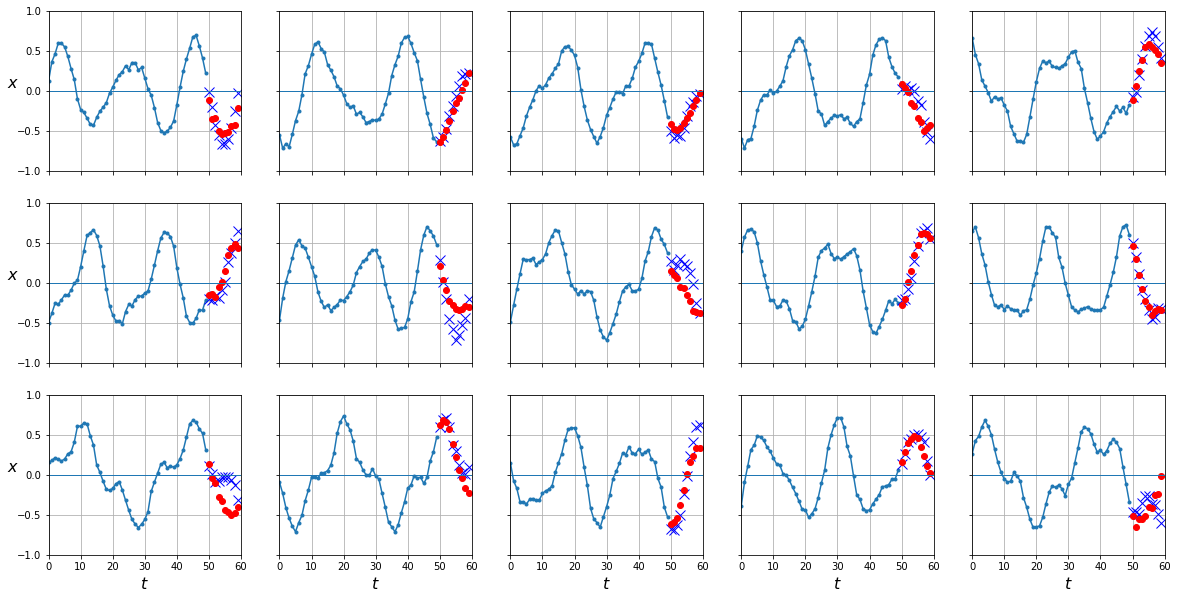

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.022594284

In [69]:
y_pred = predict(rnn_deep_10, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

# Oberveaciones

Se entrenaron dos modelos con el mismo learning rate, la misma cantidad de EPOCHS y con los mismos datos. Se observa que para estas condiciones el modelo de RNN tiene un mejor error cuadratico medio en la estimacion final que el modelo MLP.